In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import itertools
import random
import librosa
from keras import backend as K

In [2]:
mnist = tf.keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train/255
X_test = X_test/255

X_train_scaled = (X_train - 0.5) * 2.0

Y_train_onehot = tf.keras.utils.to_categorical(Y_train, num_classes=10)
Y_test_onehot = tf.keras.utils.to_categorical(Y_test, num_classes=10)

In [3]:
def build_generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(200, input_shape = (200, ), activation='relu', kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dense(400, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dense(784, activation='tanh'))
    
    gen_in = tf.keras.layers.Input(shape= (100,))
    gen_cond = tf.keras.layers.Input(shape= (100,))
    concat = tf.keras.layers.Concatenate(axis = -1)([gen_in, gen_cond])
    img = model(concat)
    
    return  tf.keras.models.Model([gen_in, gen_cond], img)

generator = build_generator()
# generator.summary()

In [25]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(400, input_shape = (784,), activation='relu', kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dense(200, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
    
    disc_in = tf.keras.layers.Input(shape= (784,))
    prediction = model(disc_in)
    
    return tf.keras.models.Model(disc_in, prediction)

discriminator = build_discriminator()
# discriminator.summary()

In [26]:
def custom_loss(real_output, fake_output, gen_cond, center_patch_pred):
    gan_loss = tf.keras.losses.binary_crossentropy(real_output, fake_output)
    mse_loss = tf.keras.losses.mean_squared_error(gen_cond, center_patch_pred)
    lambda_value = 0.7
    return gan_loss + lambda_value * mse_loss

In [ ]:
batch_size = 100
num_epochs = 100
optimizer =  tf.keras.optimizers.legacy.Adam(0.0002, 0.5)

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        
        real_images = X_train_scaled[i:i+batch_size]
        real_images_flat = real_images.reshape(len(real_images), -1)

        center_patch = real_images[:, 10:20, 10:20]
        gen_cond = center_patch.reshape(len(center_patch), -1)
         
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_in = tf.random.normal((batch_size, 100))
            gen_out = generator([gen_in, gen_cond], training=True)

            real_output = discriminator(real_images_flat, training=True)
            fake_output = discriminator(gen_out, training=True)
            
            gen_out_2d = tf.reshape(gen_out, [-1, 28, 28])
            center_patch_pred = gen_out_2d[:, 10:20, 10:20]
            center_patch_pred = tf.reshape(center_patch_pred, [-1, 100])

            gen_loss = custom_loss(real_output, fake_output, gen_cond, center_patch_pred)
            disc_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1 - fake_output))
            
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [16]:
def discriminant_images(cond, mnist_labels, mnist_data):
    
    selected_images = []
    
    for label in cond:
        indices = np.where(mnist_labels == label)[0]
        selected_index = np.random.choice(indices)
        selected_images.append(mnist_data[selected_index])
    
    selected_images = np.array(selected_images)
    
    return selected_images

In [17]:
cond = np.repeat(np.arange(10), 10)
original_images = discriminant_images(cond, Y_train, X_train_scaled)
print(original_images.shape)

(100, 28, 28)


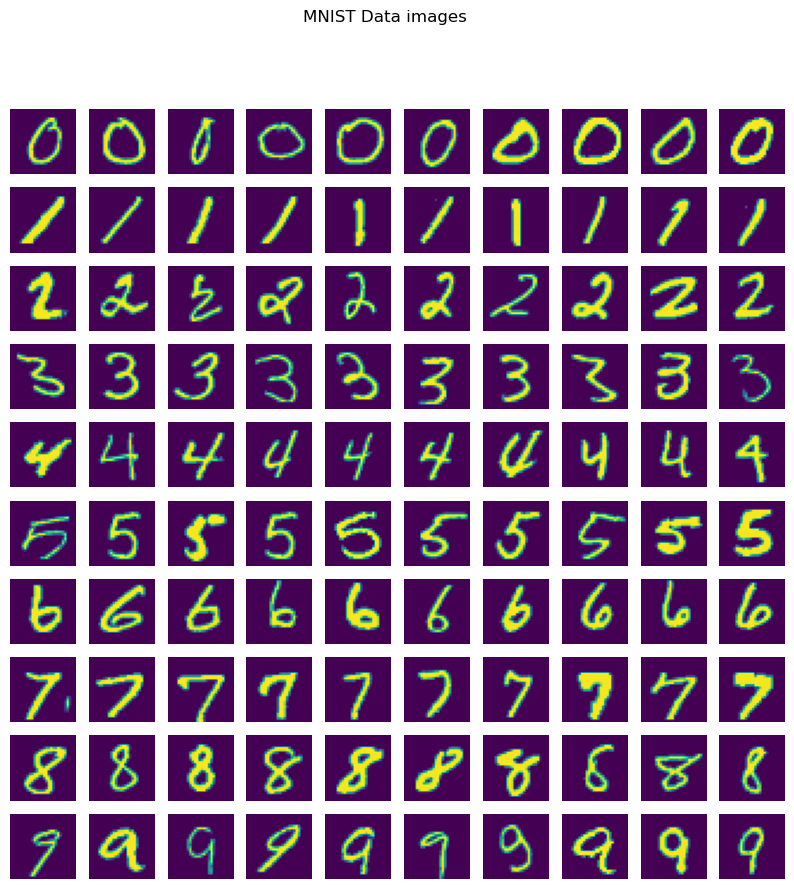

In [18]:
plt.figure(figsize=(10, 10))
plt.suptitle('MNIST Data images')
for i in range(10):
    for j in range(10):
        ax=plt.subplot2grid((10, 10), (i, j))
        image = original_images[i*10+j]
        ax.imshow(image)
        plt.axis('off')


In [31]:
center_patch = original_images[:, 10:20, 10:20]
gen_cond = center_patch.reshape(len(center_patch), -1)
gen_in = np.random.normal(0, 1, size=(100, 100))
gen_out = generator.predict([gen_in, gen_cond], verbose=0)

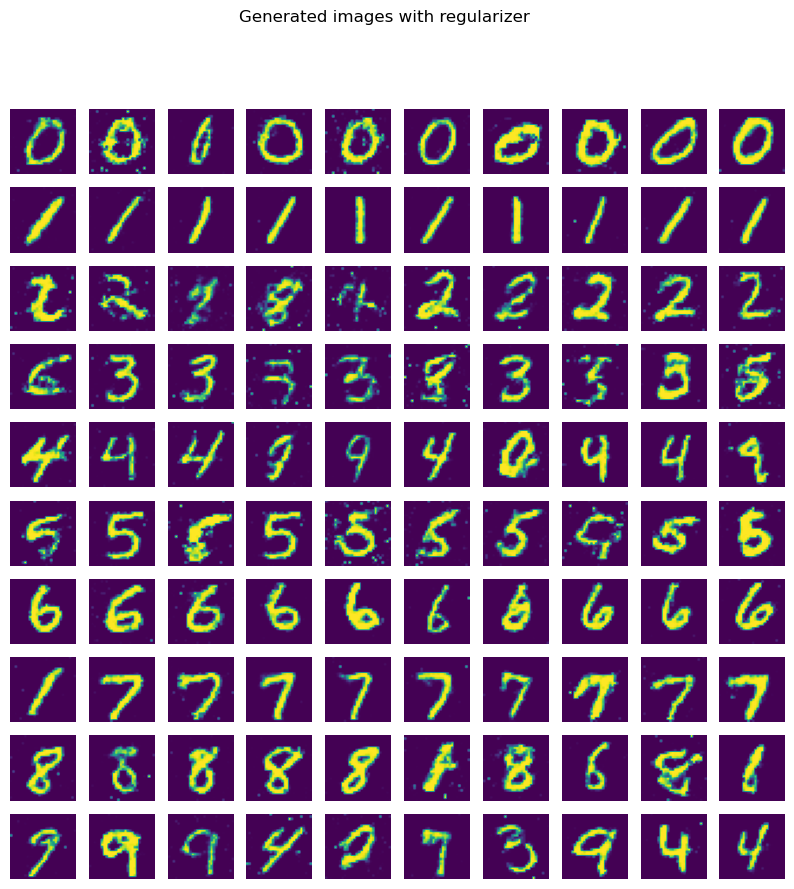

In [33]:
plt.figure(figsize=(10, 10))
plt.suptitle('Generated images with regularizer')
for i in range(10):
    for j in range(10):
        ax=plt.subplot2grid((10, 10), (i, j))
        image = gen_out[i*10+j]
        image_2d = tf.reshape(image, (28, 28))
        ax.imshow(image_2d)
        plt.axis('off')
